In [1]:
import os
import pandas as pd
import numpy as np
import top_order_book as tob
import data_parse
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from time import process_time

In [2]:
from scipy.optimize import curve_fit

# Mathematical Functions fed into optimization
def scale_function(x, alpha, beta):
    """
    Scaling function #1
    Two parameters
    
    Parameters
    ----------
    x : np.array()
        x-axis data
    alpha: float
        small x growth power
    beta: float
        large x growth power
        
    Returns: np.array() with the same shape as x
    ----------
    """
    return x / np.power(1 + np.power(abs(x), alpha), beta/alpha)

def func(qT, chi, kappa, alpha, beta, gamma):
    """
    Function used for optimization #1
    
    Parameters
    ----------
    x : np.array()
        x-axis data
    alpha: float
        small x growth power
    beta: float
        large x growth power
    chi: float
        scaling exponent of x, typically in [0.5, 1]
    kappa: float
        scaling exponent of y, typically in [0.5, 1]
    gamma: float
        if x and y properly normalized, gamma should be 1
    
    Returns: np.array() with the same shape as one colume of x
    ----------
    """
    # Separate input array
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function( x, alpha, beta ) * gamma


def scale_function_2(x, zeta):
    """
    Scaling function #2
    Two parameters
    
    Parameters
    ----------
    x : np.array()
        x-axis data
    zeta: float
        large x growth power
        
    Returns: np.array() with the same shape as x
    ----------
    """
    return x * np.sign(x) * np.power(np.abs(x), zeta)

def func_2(qT, chi, kappa, zeta, gamma):
    """
    Function used for optimization #2
    
    Parameters
    ----------
    x : np.array()
        x-axis data
    zeta: float
        large x growth power
    chi: float
        scaling exponent of x, typically in [0.5, 1]
    kappa: float
        scaling exponent of y, typically in [0.5, 1]
    gamma: float
        if x and y properly normalized, gamma should be 1
    
    Returns: np.array() with the same shape as one colume of x
    ----------
    """
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function_2( x, zeta ) * gamma


def scale_function_3(x):
    """
    Scaling function #3
    Pure sigmoid function [-1, 1]
    
    Parameters
    ----------
    x : np.array()
        x-axis data
        
    Returns: np.array() with the same shape as x
    ----------
    """
    return np.tanh(x)

def func_3(qT, chi, kappa, gamma):
    """
    Function used for optimization #3
    
    Parameters
    ----------
    x : np.array()
        x-axis data
    chi: float
        scaling exponent of x, typically in [0.5, 1]
    kappa: float
        scaling exponent of y, typically in [0.5, 1]
    gamma: float
        if x and y properly normalized, gamma should be 1
    
    Returns: np.array() with the same shape as one colume of x
    ----------
    """
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function_3( x ) * gamma

In [3]:
# input all daily impact vs imbalance data
directory = 'output/'

files = os.listdir(directory)
data = pd.DataFrame()
for file in files:
    if file.startswith(r'impact_vs_imbalance_') & file.endswith('.csv'):
        f = open(directory + file, 'r')
        data = data.append(pd.read_csv(f, index_col=0), ignore_index=True)
        f.close()

In [4]:
# header incorrect, need renaming
data.columns = ['qi', 'yi', 'T']

# reoganize columes
data = data.reindex(columns=['qi', 'T', 'yi'])

data

,qi,T,yi
0,-0.000400,5,0.000000
1,-0.000384,5,0.000000
2,-0.000349,5,0.000000
3,-0.000342,5,0.000000
4,-0.000322,5,0.000000
...,...,...,...
104170,0.002008,100,19.912864
104171,0.002334,100,11.378780
104172,0.002528,100,14.223475
104173,0.003592,100,0.000000


In [5]:
durations = [5, 10, 20, 50, 100]

In [6]:
popt, pcov = curve_fit(func, np.transpose(data.iloc[:, :2].to_numpy()), 
                       data.iloc[:, 2].to_numpy(), 
                       bounds=(0, np.inf))
print(popt)
print(np.sqrt(np.diag(pcov)))

[5.79720026e-01 6.54594339e-01 2.53632415e-01 1.32642882e+01
 1.31499666e+06]
[7.72174306e-03 3.21090472e-02 8.70867729e-03 1.07251663e+00
 2.48316839e+05]


In [7]:
popt2, pcov2 = curve_fit(func_2, np.transpose(data.iloc[:, :2].to_numpy()), 
                       data.iloc[:, 2].to_numpy(), 
                       bounds=(0, np.inf))
popt2

array([0.57723377, 2.26636041, 2.47871076, 0.82389058])

In [8]:
popt3, pcov3 = curve_fit(func_3, np.transpose(data.iloc[:, :2].to_numpy()), 
                       data.iloc[:, 2].to_numpy(), 
                       bounds=(0, np.inf))
popt3

array([9.33334735e-01, 5.65985912e-01, 3.87090689e+03])

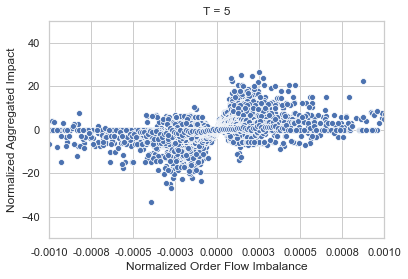

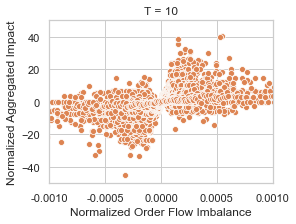

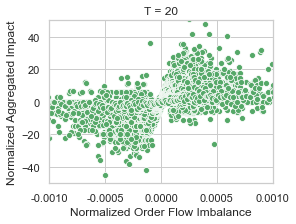

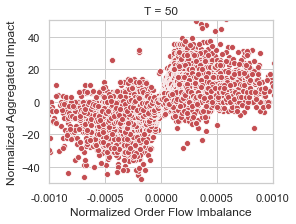

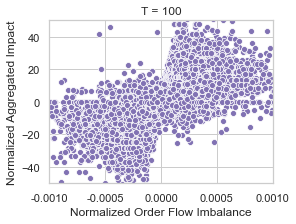

In [9]:
# graph 1: full data
for idx, T in enumerate(durations):
    temp = data[data['T'] == T]

    # plotting in seaborn
    sns.set(style='whitegrid')
    ax = sns.scatterplot(x='qi', y='yi', data=temp, color='C'+str(idx))
    ax.set(xlabel='Normalized Order Flow Imbalance', 
           ylabel='Normalized Aggregated Impact')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.4f}"))
    plt.title('T = ' + str(T))
    plt.xlim(-0.001, 0.001)
    plt.ylim(-50, 50)
    plt.rcParams['figure.figsize'] = (4, 3)
    #fig = ax.get_figure()
    #fig.savefig('figs/fig_' + str(T) + '.png')
    plt.show()

In [10]:
# Too much noise, will need binning
data_binned = pd.DataFrame()

for T in durations:
    temp = data[data['T'] == T]
    qmax = 0.0005
    bin_size = 31
    
    # limit value for 'qi'
    temp = temp[(temp['qi'] > -qmax) & (temp['qi'] < qmax)]
    
    # bin
    temp['bin'] = pd.qcut(temp['qi'], bin_size)
    
    # find average
    temp = temp.groupby(['bin']).mean().reset_index()
    data_binned = data_binned.append(temp.iloc[:, 1:], ignore_index=True)

In [11]:
data_binned

,qi,T,yi
0,-0.000367,5,-2.089363
1,-0.000258,5,-2.779359
2,-0.000213,5,-2.606891
3,-0.000180,5,-2.467505
4,-0.000156,5,-2.793818
...,...,...,...
150,0.000212,100,13.288235
151,0.000243,100,13.188393
152,0.000281,100,13.239021
153,0.000335,100,13.924957


In [12]:
n = 1001

# T matrix matching with x-axis
T_array = np.array(durations)
T_mat = np.transpose(np.tile(T_array, (n, 1)))

# repeat x-axis sample for 
q = np.linspace(-qmax, qmax, n)
q_mat = np.tile(q, (len(T_array), 1))

# function to feed in func need to be flatten
q_data = q_mat.flatten()
T_data = T_mat.flatten()
qT_data = np.array( [q_data, T_data] )
qT_data.shape

# check dimensions
print(T_mat.shape)
print(q_mat.shape)

(5, 1001)
(5, 1001)


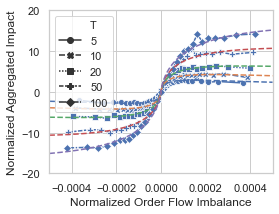

In [13]:
# plotting in seaborn
ax = sns.lineplot(x='qi', y='yi', data=data_binned, style="T", 
             markers=True, legend='brief')
for idx, t in np.ndenumerate(T_array):
    plt.plot(q, func(np.array( [q, T_mat[idx[0]]] ), *popt), 
             '--', 
             color='C'+str(idx[0]), 
             label='T = '+str(T_mat[idx[0], 1]))
ax.set(xlabel='Normalized Order Flow Imbalance', 
           ylabel='Normalized Aggregated Impact')
plt.xlim(-qmax, qmax)
plt.ylim(-20, 20)
plt.rcParams['figure.figsize'] = (16, 12)
plt.show()

In [14]:
# plotting with scaled 
data_binned['x_scaled'] = data_binned['qi'] / np.power(data_binned['T'], popt[1])
data_binned['y_scaled'] = data_binned['yi'] / np.power(data_binned['T'], popt[0])

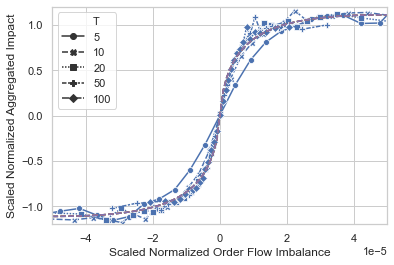

In [17]:
# plotting in seaborn
ax = sns.lineplot(x='x_scaled', y='y_scaled', data=data_binned, style="T", 
             markers=True, legend='brief')
for idx, t in np.ndenumerate(T_array):
    plt.plot(q, scale_function(q, popt[2], popt[3]) * popt[-1], 
             '--', 
             color='C'+str(idx[0]), 
             label='T = '+str(T_mat[idx[0], 1]))
ax.set(xlabel='Scaled Normalized Order Flow Imbalance', 
           ylabel='Scaled Normalized Aggregated Impact')
plt.xlim(-qmax/10, qmax/10)
plt.ylim(-1.2, 1.2)
plt.rcParams['figure.figsize'] = (6, 4)
plt.show()